# Integration with adult Pan-immune data - Myeloid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys,os
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as scv

In [208]:
## import utils
cwd = '.'
sys.path.append(cwd)

import map_query_utils

In [5]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython


In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
def _plot_sorted_violin(merged_adata_bcells, groupby, y_value):
    n_cells_anno = merged_adata_bcells.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = merged_adata_bcells.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    merged_adata_bcells.var_names_make_unique()
    plt.rcParams["figure.figsize"] = [14,6]
    sc.pl.violin(merged_adata_bcells[merged_adata_bcells.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)

## Prepare data for mapping 

### Load full PIP dataset 

Provided by Cecilia, and re-saved by me to have EnsemblIDs as `var_names`

In [9]:
pi_adata = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/panimmune_query.h5ad')

### Subset to lymphoid cells

In [10]:
mye_pi_adata = pi_adata[~pi_adata.obs["anno_mye"].isna()]

In [16]:
mye_pi_adata

View of AnnData object with n_obs × n_vars = 13062 × 33694
    obs: 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'n_genes', 'n_counts', 'log_counts', 'batch', 'empty', 'bonf_pval', 'is_doublet', 'scrublet_score', 'louvain', 'louvain_R', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'leiden5', 'leiden10', 'leiden15', 'leiden20', 'cx1_anno', 'leiden_majority_anno', 'leiden1.5', 'anno', 'anno_mye', 'anno_T_2', 'anno_B_v2'
    var: 'gene_ids', 'feature_types', 'gene_names'

In [12]:
mye_pi_adata.write_h5ad("/nfs/team205/ed6/data/Fetal_immune/panimmune_MYELOID_query.h5ad")
mye_pi_adata.write_h5ad("/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/panimmune_MYELOID_query.h5ad")

### Save MYELOID scVI model with EnsemblIDs

In [15]:
split = "MYELOID"
timestamp="20210429"
scvi_outs_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'

## Read old varnames
model_dir='scvi_' + split + '_model/'
var_names_model = pd.read_csv(scvi_outs_dir + model_dir + "var_names.csv", header=None)[0].values

## Make new model folder for model with EnsemblIDs
new_model_dir = model_dir.strip("/") +"_ENSID/"
bash_call = 'cp -r {o} {n}'.format(o=scvi_outs_dir + model_dir, n=scvi_outs_dir+new_model_dir)
os.system(bash_call)

## Save var_names
adata_ref_var = pd.read_csv(scvi_outs_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.var.csv'.format(t=timestamp, s=split), index_col=0)
adata_ref_var.iloc[var_names_model]['GeneID'].to_csv(scvi_outs_dir + new_model_dir + "var_names.csv", header=None, index=False)

### Train on scVI models

On GPU node, running the call:

We merge datasets and rerun embeddings running

### Load output

In [23]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'

In [19]:
merged_adata_file = 'panimmune_MYELOID_query.mapped2MYELOID.withReference.h5ad'
split = "MYELOID"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
timestamp = '20210429'

In [20]:
merged_adata = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [21]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
exclude_obs = reference_obs[reference_obs.str.strip("-reference").isin(mat_barcodes)]

merged_adata = merged_adata[~merged_adata.obs_names.isin(exclude_obs)].copy()

In [24]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

# merged_adata.obs["organ"] = np.nan
# merged_adata.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values
# merged_adata.obs["age"] = np.nan
# merged_adata.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
## Add metadata and annotations for the query
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
merged_adata.obs["annotation_query"] = merged_adata.obs["anno_mye"]

... storing 'annotation_reference' as categorical


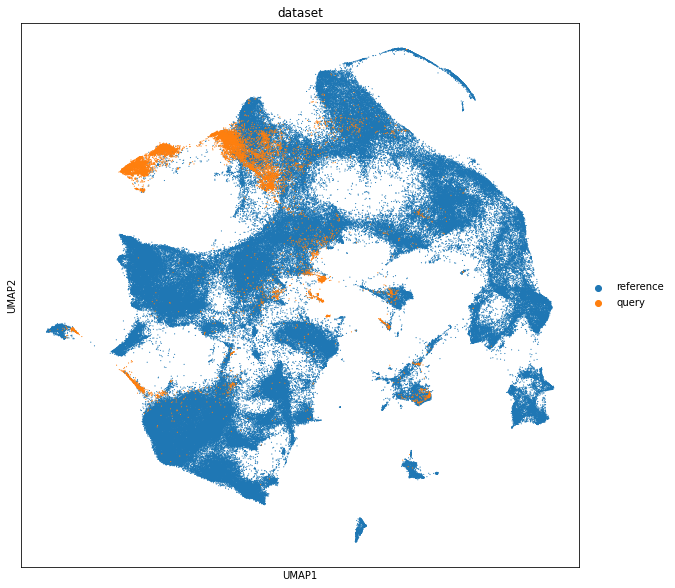

In [28]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_adata, color=["dataset"], size=5)

### Plot query and reference annotations

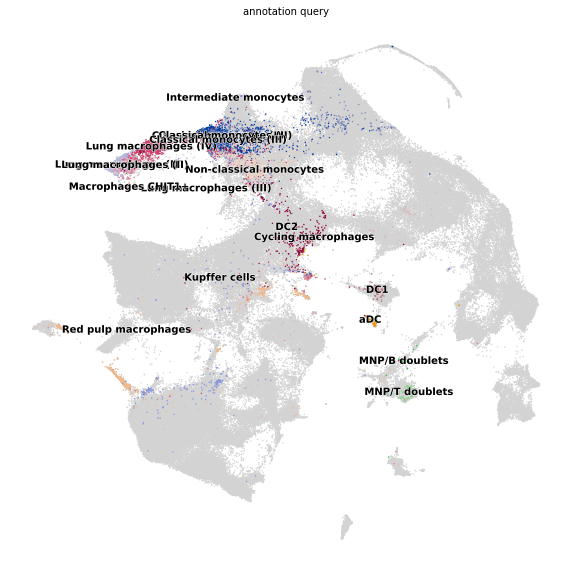

In [31]:
anno_labels = merged_adata.obs["annotation_query"][merged_adata.obs["annotation_query"]!="nan"].unique().tolist()
scv.pl.umap(merged_adata, color=["annotation_query"], size=8, legend_loc="on data", groups=anno_labels, title="annotation query")

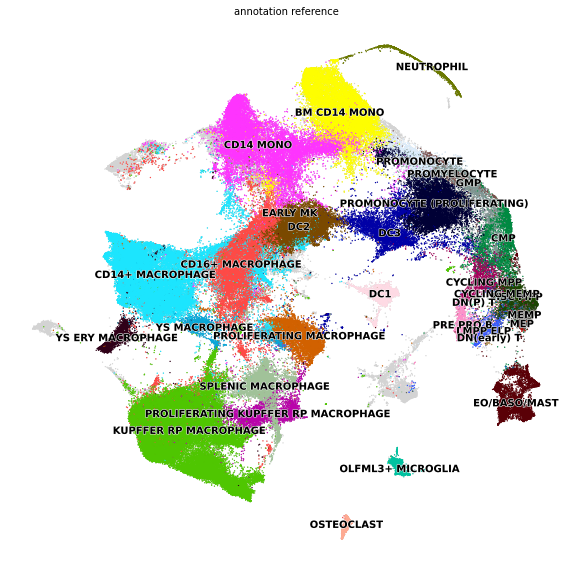

In [32]:
anno_labels = merged_adata.obs["annotation_reference"][merged_adata.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]

scv.pl.umap(merged_adata, color=["annotation_reference"], size=7, legend_loc="on data", groups=anno_labels, 
            legend_fontsize=10,
            title="annotation reference")

### Transfer labels

In [33]:
merged_adata.obs["annotation_reference"] = merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
map_query_utils.predict_label(merged_adata, anno_col="annotation_reference")

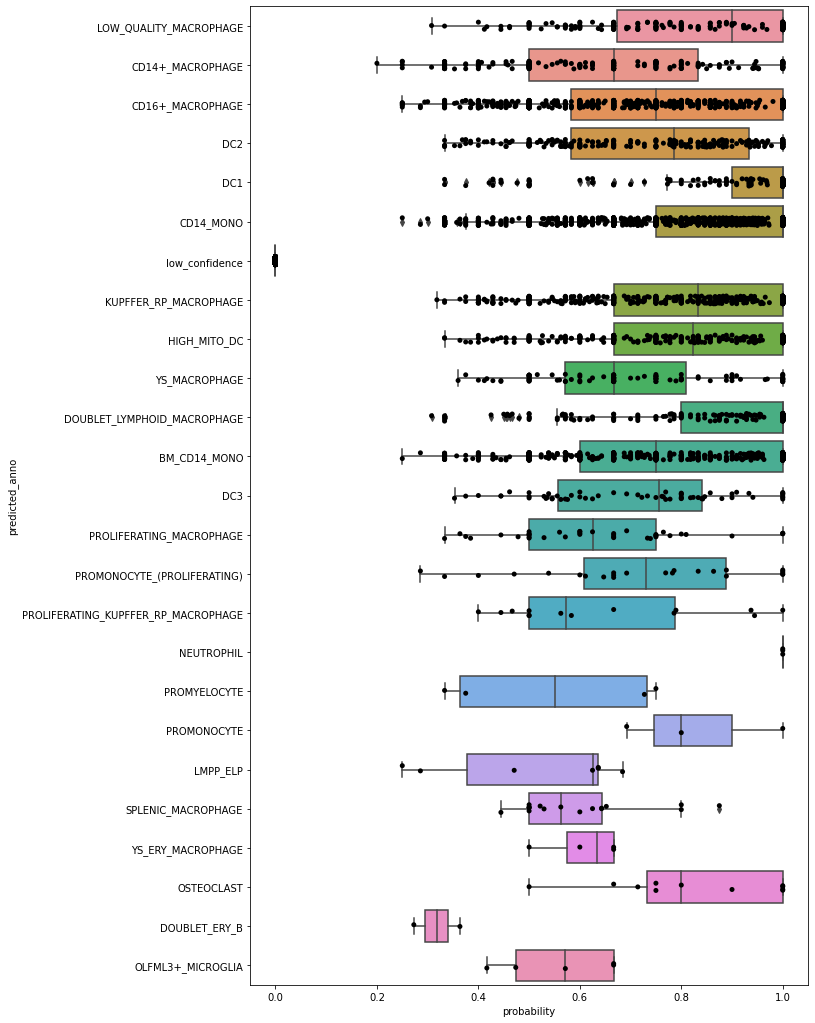

In [34]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(merged_adata)

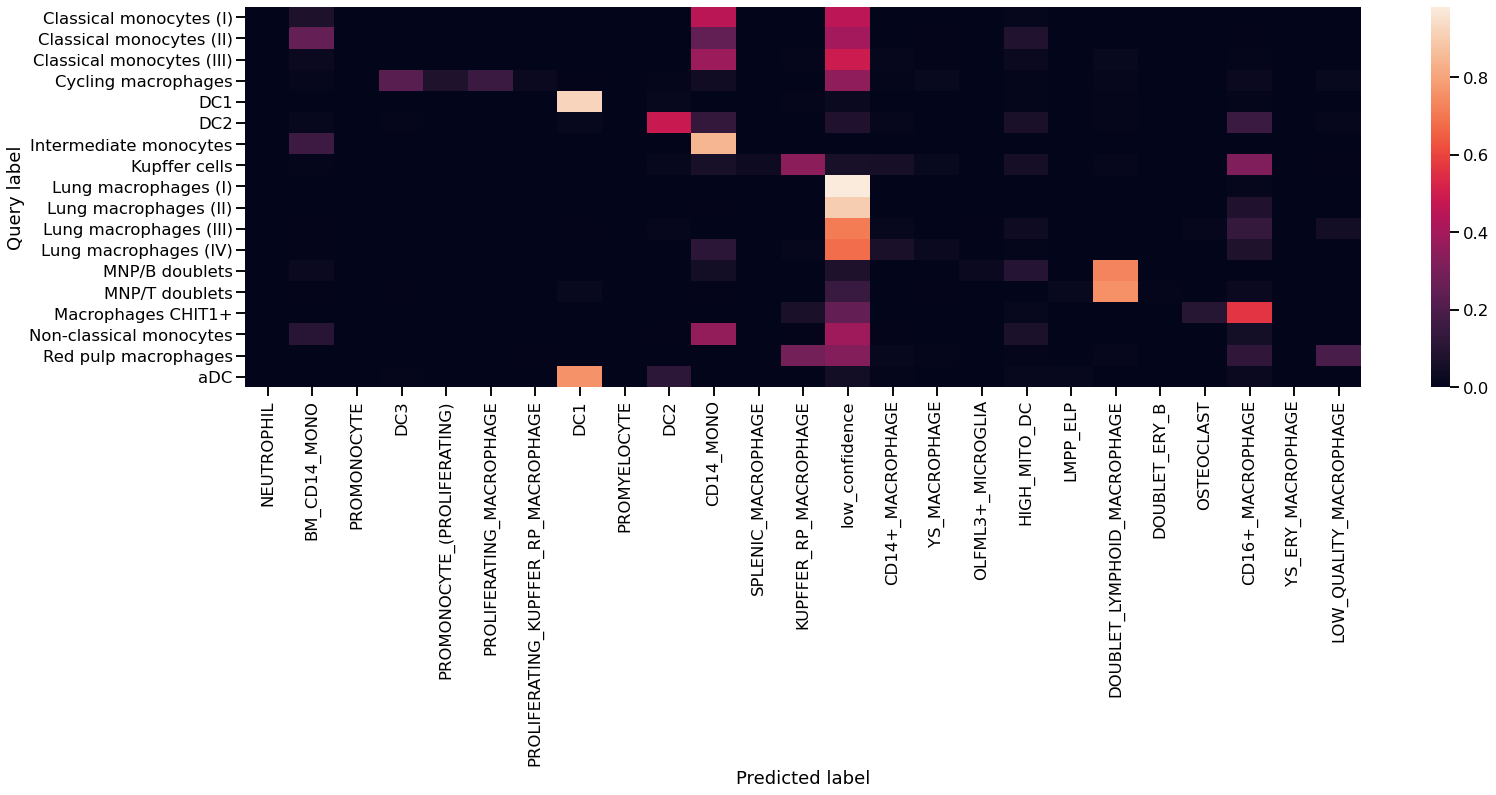

In [35]:
sns.set_context("talk")
query_anno_col="annotation_query"

query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
empty_query = query_obs[merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = merged_adata[~merged_adata.obs_names.isin(empty_query)]

plt.rcParams["figure.figsize"] = [25,7]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)

### Quantify matching between datasets

In [198]:
import time
start = time.time()
mnn_query, mnn_ref = map_query_utils._find_MNNs(merged_adata)
end = time.time()
print(end - start)

26.441299200057983


In [209]:
map_query_utils._MNN_to_KNN_similarity_ratio(merged_adata, mnn_ref, mnn_query)

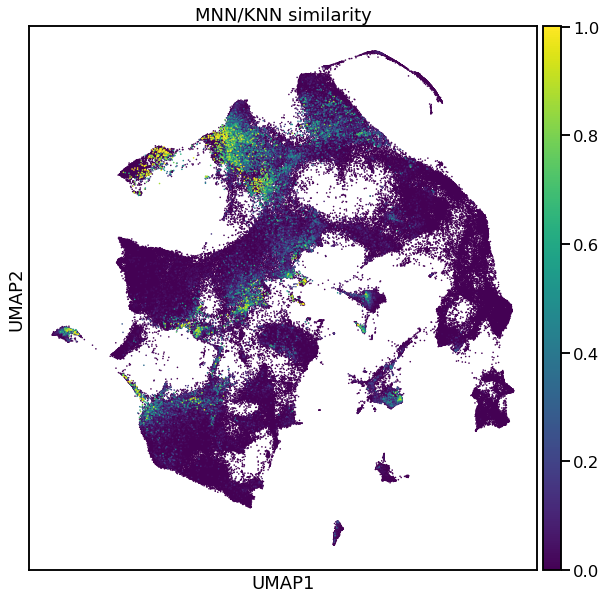

In [210]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")
sc.pl.umap(merged_adata, color="mnn_sim_ratio", size=10, title="MNN/KNN similarity")

In [ ]:
merged_adata.

LinAlgError: singular matrix

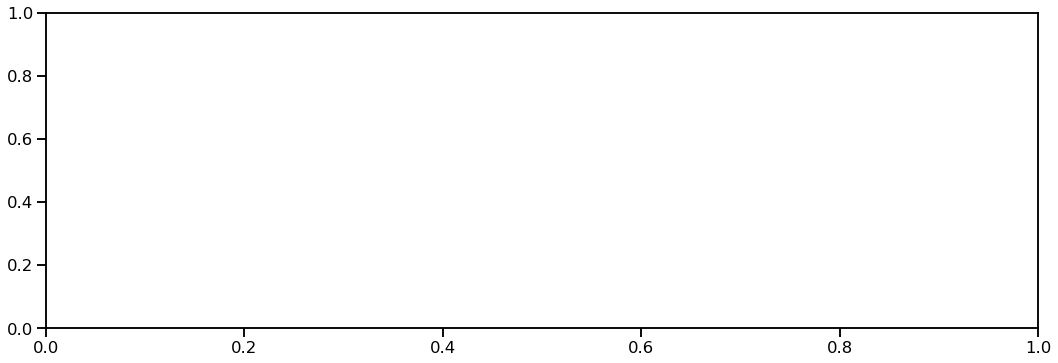

In [214]:
sc.pl.violin(merged_adata, "mnn_sim_ratio", groupby="annotation_query")
sc.pl.violin(merged_adata, "mnn_sim_ratio", groupby="annotation_reference")
# _plot_sorted_violin(merged_adata, "annotation_reference", "mnn_sim_ratio")

### Save outputs

In [212]:
merged_adata.write_h5ad(data_dir + merged_adata_file)

In [215]:
data_dir

'/nfs/team205/ed6/data/Fetal_immune/'